# Project

In [1]:
%matplotlib inline
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import *
import tdmclient.notebook
await tdmclient.notebook.start()


In [2]:
# parametres
speed_r = 100
speed_f = 100
stop = 0
MIN_DIST = 40
ANGLE_TOLERANCE = 0.30
PERIOD = 0.25
SPEED_AVG = 150
ROBOT_SPEED_TO_MM = 140/500

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

In [3]:
def controller(goal_dist, angle):
    kp_rot = 50

    if abs(angle) > ANGLE_TOLERANCE:
        speed_l = - kp_rot*(angle)
        speed_r = + kp_rot*(angle)

    else:
        speed_l = SPEED_AVG
        speed_r = SPEED_AVG
    return int(speed_l), int(speed_r)

In [4]:
def pathing (video_capture, filter, path, x0, y0, theta0, periode=0.01):
    # plot for camera, kalman and error
    teta = np.zeros(np.shape(path)[0])
    speed_l = speed_r = 0
    goalx = path[0][0]
    goaly = path[0][1]
    theta_measure = 0
    i = 0
    curr_time = 0
    kx = kteta = ky = angle = 0
    robot_detected = False
    camera_available = False
    dist = distance (goalx, goaly, kx, ky)
    
    # kalman variables 
    P = 1000*np.eye(3)
    x = x_predicted = np.array([[0],[0],[0]])
    z = np.array([[0],[0],[0]])
    u = np.array([[0],[0]])
    previous_time = 0
    

    while True:       
        #   step 1: get the image, detect the robot, and get the position
        camera_available, frame = video_capture.read()
        position_measure = []
        if camera_available == True:
            position_measure, position_contour, proccessed_framed = computer_vision(frame, 'robot', False)
            # cv has detected the robot, we can use the position
            if len(position_measure) == 1:
                robot_detected = True
                position_measure = position_measure[0]

                if position_measure is not None:                    
                    _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                    theta_measure = round(-theta_measure, 4)
                    position_measure = invert_coordinates(position_measure)
                    position_measure = pixel_to_metric(position_measure)
                    [kx, ky, kteta] = [position_measure[0], position_measure[1], theta_measure]
                    measurement = np.array([kx, ky, kteta])
                else:
                    robot_detected = False
            else:
            # robot not detected, we use kalman
                robot_detected = False

        if camera_available == False or robot_detected == False:
            measurement = np.array([0,0,0])         # CHECK WHY 0,0,0            
        
        #[pred_x, pred_y, pred_teta], _, _, curr_time = filter.filter(measurement, curr_time) 
        z = np.array([[measurement[0]], [measurement[1]], [measurement[2]]])
        previous_time, x, P, x_predicted = kalman_filter(robot_detected, x, u, z, P , previous_time)
        [pred_x, pred_y, pred_teta] = x
        
        #dist = distance (goalx, goaly, kx, ky)
        dist = distance (goalx, goaly, pred_x, pred_y)
        #teta[i] = math.atan2((goaly - ky), (goalx - kx)) #change angle according to kalman
        teta[i] = math.atan2((goaly - pred_y), (goalx - pred_x)) #change angle according to kalman
    

        if (dist < MIN_DIST):
            if i < np.shape(path)[0] - 1 :
                i = i + 1
                goalx = path[i][0]
                goaly = path[i][1]
                #vec1 = [np.cos(teta[i-1]), np.sin(teta[i-1])]
                #vec2 = [goalx - kx, goaly - ky]
                #angle = get_angle_between(vec1, vec2)
            else:
                motors(stop, stop)
                break
        else :
            angle =  wrap_angle((teta[i] - pred_teta) % (2*np.pi))
            
            speed_l, speed_r = controller(dist, angle)
   
        # set input for kalman filter
        #filter.u = np.array([speed_l, speed_r]) * ROBOT_SPEED_TO_MM
        u = np.array([[speed_l],[speed_r]]) * ROBOT_SPEED_TO_MM
        motors(speed_l, speed_r)
     
     
        print(robot_detected, round(theta_measure,4),i, filter.dt, "error :%.3f %.3f %.4f" %(kx-pred_x, ky-pred_y, kteta-pred_teta))
    motors(stop, stop)
    

# Main 

1
2
3
start = [ 42.08082 417.85516] goal = [703.56178 682.15224] angle = 0.04946456860159136


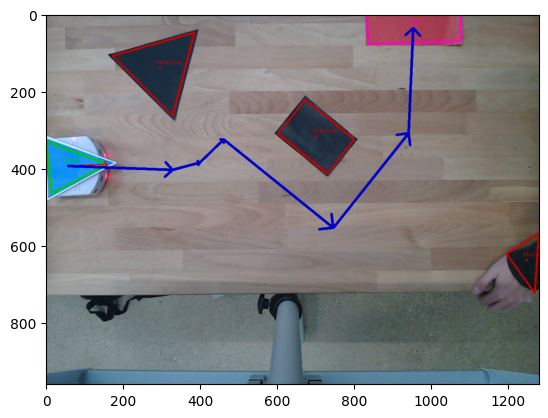

In [5]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-7)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)

if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
        
    metric_path = np.zeros(np.shape(path))

    # invert y axis
    for i in range(len(path)):
        path[i] = invert_coordinates(path[i])
    metric_start = invert_coordinates(start)
    metric_goal = invert_coordinates(goal)

    # change to metric  

    for i in range(len(path)):
        metric_path[i] = pixel_to_metric(path[i])
    metric_start = pixel_to_metric(metric_start)
    metric_goal = pixel_to_metric(metric_goal)
    
    
    print('start =', metric_start, 'goal =', metric_goal, 'angle =', -robot[2])


filter = kalman_ext_filter(metric_start[0], metric_start[1], -robot[2], 0, 0, PERIOD)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [6]:
#ret, frame = video_capture.read()
#print(ret)
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#cv2.imwrite('frame.jpeg', frame)

motors(stop, stop)
np.shape(path)
print(np.shape(path)[0])

8


In [7]:
pathing(video_capture, filter, metric_path, metric_start[0], metric_start[1], -robot[2], periode=PERIOD)
print("finished")
motors(stop, stop)


0.0495 1 0.25 error :0.002 0.017 0.0000
0.0495 1 0.25 error :-0.000 0.008 0.0000
0.0495 1 0.25 error :-0.000 0.006 0.0000
0.0495 1 0.25 error :-0.000 0.004 0.0000
0.079 1 0.25 error :0.480 -0.265 0.0008
0.079 1 0.25 error :0.790 -0.237 0.0000
0.0692 1 0.25 error :0.904 -0.302 -0.0003
0.0783 1 0.25 error :0.890 -0.246 0.0003
0.0679 1 0.25 error :0.805 -0.275 -0.0003
0.0685 1 0.25 error :0.819 -0.836 0.0000
0.0775 1 0.25 error :0.880 -0.770 0.0003
0.0582 1 0.25 error :0.850 -0.754 -0.0006
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 error :0.879 -0.622 0.0003
0.0672 1 0.25 er